# COVID 19 - Compartmental Model Simulation

<img src="COVIDbanner.png" width="1000"> 

## Model

The notebook introduces the compartmental stochastic model developed by Gareth et al. (2011)[https://arxiv.org/abs/1108.3137v1]. The COVID-19 model is using Bayesian methods to jointly estimate information from a stochastic mixing matrix that quantifies sexual interaction patterns by age and gender with parameters from a system of high-dimensional ODEs. This stochastic mixing matrix relies on quantities that are a priori unknown. 

The aims of our research is to evaluate the model under new conditions and also improve its inference time.

1. Explore the performance of the model under COVID-19 conditions
2. Improve the calibration time of the model by utilising Stochastic Approximate Inference Methods [Damianou et al.](https://arxiv.org/pdf/1409.2287.pdf).
3. Expand the model capacity by incorporating social mixing matrix methods, such as from POLYMOD and BBC Science [Diekmann et al.](https://royalsocietypublishing.org/doi/10.1098/rsif.2009.0386)

<img src="COVIDb.png" width="1000"> 

From the graph above, we define the following compartments:
- **$S$** is individuals who are at risks of Covid-19 infection
- **$I$** is infected individuals including asymptomatic and mild cases
- **$G$** is infected people who developed more severe cases of symptoms and required hospitalization
- **$P$** is those who recovered, and are seropositive and immune
- **$N$** is individuals who are recovered, immune but seronegative

We also introduce the attributes age ($a$), gender ($g$) and social activity group ($s$) differentiating individuals in a population.

- $a$ : age - is 5-year band
- $g$ : gender - male = 0, female = 1
- $s$ : social intereaction category - active = 1, not active = 0

$r = 5 * 365 = 1825$

$R = 2 * 2 * 1825 = 7300$

An important metric used to characterised the epidemic is $\mathcal{R}_0$ which is defined as:

$$
\mathcal{R}_0 = \tau \cdot \bar{c} \cdot d
$$

$\tau$ : the transmissibility (i.e., probability of infection given contact between a susceptible and infected individual)

$\bar{c}$ :  the average rate of contact between susceptible and infected individuals

$d$ : the duration of infectiousness

$\mathcal{R}_0$ is estimated to be between $2.76$ and $3.25$.

## Code

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors
np.random.seed(123)

tf.compat.v1.flags.DEFINE_string('f', '', 'kernel')

np.concat = np.concatenate

STATES = ['S', 'I', 'G', 'P', 'N']

ages = np.arange(0, 101, 25, np.int32)

A_CATEGORIES = [str(t) for t in zip(ages, ages[1:])]
G_CATEGORIES = ["male", "female"]
S_CATEGORIES = ["high", "low"]

Based on the mixing matrix we derive the force of infection $\lambda$

\begin{equation}
\lambda_{g,s,a}=\beta_{g}\sum_{s^{'}, \alpha^{'}} \bigg\{ c^{*}_{g,s,s^{'},\alpha,\alpha^{'}} \frac{I_{g^{'}, s^{'}, \alpha{'}}}{S_{g^{'}, s^{'}, \alpha{'}} + I_{g^{'}, s^{'}, \alpha{'}} + G_{g^{'}, s^{'}, \alpha{'}} + P_{g^{'}, s^{'}, \alpha{'}} + N_{g^{'}, s^{'}, \alpha{'}} } \bigg\}
\end{equation}

In [2]:
def _intensity_np(t, g, s, a, S, I, G, P, N, beta, c):
    left, right = I, (S + I + G + P + N)
    opposite_group_ratio = np.divide(left, right, out=np.zeros_like(left), where=right!=0)
    infectious_interactions = np.sum(c[g,:, s,:, a,:] * opposite_group_ratio)
    return beta[g] * infectious_interactions
    
def _intensity_tf(t, g, s, a, S, I, G, P, N, beta, c):
    opposite_group_ratio = tf.math.divide_no_nan(I, (S + I + G + P + N))
    infectious_interactions = tf.reduce_sum(c[g,:, s,:, a,:] * opposite_group_ratio)
    return beta[g] * infectious_interactions
    
# Force of infection lambda
def intensity(framework, *args):
    if framework == np:
        return _intensity_np(*args)
    elif framework == tf:
        return _intensity_tf(*args)

The script below describes the ODEs

\begin{align*}
\tag{1}
& \dot{S}_{g,s,a} & = & -\lambda_{g,s,a}(t)S_{g,s,a} + (P_{g,s,a} + N_{g,s,a})/DI_g + \frac{1}{r}S_{g,s,a-1} - \frac{1}{r}S_{g,s,a} + &\\
&&& \frac{1}{R}\sum_{g,s}(S_{g,s,20} + I_{g,s,20} + G_{g,s,20} + P_{g,s,20} + N_{g,s,20}) \times &\\
&&& \delta_1(a)(\pi_1\delta_1(s) + \pi_2\delta_2(s) + \pi_3\delta_3(s) + \pi_4\delta_4(s)) &\\ \\
\tag{2}
& \dot{I}_{g,s,a}  & = &  \lambda_{g,s,a}(t)S_{g,s,a} - (1/WIP_g + 1/DAI_g)I_{g,s,a} + \frac{1}{r}I_{g,s,a-1}-\frac{1}{r}I_{g,s,a} &\\ \\
\tag{3}
& \dot{G}_{g,s,a}  & = &  I_{g,s,a}/WIP_g - G_{g,s,a}/DWT_g + \frac{1}{r}G_{g,s,a-1} - \frac{1}{r}G_{g,s,a} &\\ \\ 
\tag{4}
& \dot{P}_{g,s,a}  & = &  PSC_g(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - P_{g,s,a}/DI_g + \frac{1}{r}P_{g,s,a-1} - \frac{1}{r}P_{g,s,a} &\\ \\
\tag{5}
& \dot{N}_{g,s,a}  & = &  (1-PSC_g)(I_{g,s,a}/DAI_g + G_{g,s,a}/DWT_g) - N_{g,s,a}/DI_g + \frac{1}{r}N_{g,s,a-1}-\frac{1}{r}N_{g,s,a} &\\ \\
\end{align*}

In [3]:
def dS(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, di=None, sip=None, r=None, framework=np, **kwargs):
    dSdt = - intensity(framework, t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] + \
        (P[g, s, a] + N[g, s, a]) / di[g] - S[g, s, a] / r + int(bool(a)) * S[g, s, a-1] / r
    
    if a != 0:
        return dSdt
        
    sum_func = tf.reduce_sum if framework == tf else np.sum
        
    R = len(G_CATEGORIES) * len(S_CATEGORIES)
    inflow = sum_func(
        sum_func([
            S[:,:,-1], 
            I[:,:,-1],
            G[:,:,-1],
            P[:,:,-1],
            N[:,:,-1]
        ]) * sip / r
    )
            
    return dSdt + inflow / R

def dI(t, g, s, a, S=None, I=None, G=None, P=None, N=None, beta=None, c=None, wip=None, dai=None, r=None, framework=np, **kwargs):
    dIdt = intensity(framework, t, g, s, a, S, I, G, P, N, beta, c) * S[g, s, a] - \
        (1/wip[g] + 1/dai[g]) * I[g, s, a] - I[g, s, a] / r + int(bool(a)) * I[g, s, a-1] / r
    
    return dIdt

def dG(t, g, s, a, I=None, G=None, wip=None, dwt=None, r=None, **kwargs):
    dGdt = I[g, s, a] / wip[g] - G[g, s, a] / dwt[g] - G[g, s, a] / r + int(bool(a)) * G[g, s, a-1] / r
    
    return dGdt

def dP(t, g, s, a, I=None, G=None, P=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dPdt = psc[g] * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - P[g, s, a] / di[g] - \
        P[g, s, a] / r + int(bool(a)) * P[g, s, a-1] / r
    
    return dPdt

def dN(t, g, s, a, I=None, G=None, N=None, psc=None, dai=None, dwt=None, di=None, r=None, **kwargs):
    dNdt = (1-psc[g]) * (I[g, s, a] / dai[g] + G[g, s, a] / dwt[g]) - \
        N[g, s ,a]/di[g] - N[g, s, a] / r + int(bool(a)) * N[g, s, a-1] / r
    
    return dNdt

In [4]:
DELTAS_FUNC = {
    "S": dS, "I": dI, "G": dG, "P": dP, "N": dN
}

def system(y, t, params, framework):
    """System of ODEs
    
    Params:
        y (array) : the current state
        t (float) : the current time
        sip (array) : the proportion of people in each social interaction group (sum(sip) = 1)
        beta (array) : the transmission probabilities
        c (array) : mean per capita at which an individual interact with a new individual from g', s', a'
        di (array) : duration of immunity
        wip (array) : incubation period
        dai (array) : duration of asymptomatic infection symptoms
        dwt (array) : duration of treatment
        psc (array) : probability of becoming seropositive
        r (int) : the number of days for someone to move to the upper age category
    """
    params = {k: v for k, v in zip(
        ["sip", "beta", "c", "di", "wip", "dai", "dwt", "psc", "r"], 
        deflatten_params(params, framework))
    }
    params["framework"] = framework
    
    states_ = framework.reshape(y, (len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
    states = {}
    for i, state in enumerate(STATES):
        states[state] = states_[i]
        
    deltas = {
        state: np.empty((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
        for state in STATES
    }

    lengths = [len(STATES), len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)]
    
    ret = [None]*np.prod(lengths)
    for i_state, state in enumerate(STATES):
        for i_g in range(len(G_CATEGORIES)):
            for i_s in range(len(S_CATEGORIES)):
                for i_a in range(len(A_CATEGORIES)):
                    idx = np.dot(
                        [i_state, i_g, i_s, i_a], 
                        [np.prod(lengths[i:] + [1]) for i in range(1, len(lengths)+1)]
                    )
                    ret[idx] = DELTAS_FUNC[state](t, i_g, i_s, i_a, **states, **params)
                    
    return ret

In [5]:
def generate_initial_state(n=100, infected_ratio=0.5, seed=123):
    """Generate a random initial state
    
    Params:
        n (int): the population size
        infected_ratio (float): the ratio of people infected in the population
        seed (int): the random seed to use
    """
    np.random.seed(seed)
    
    ages = np.random.randint(len(A_CATEGORIES), size=n)
    genders = np.random.randint(len(G_CATEGORIES), size=n)
    social_interactions = np.random.randint(len(S_CATEGORIES), size=n)
    
    initial_states = {
        state: np.zeros((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)), dtype=np.float32)
        for state in STATES
    }
    
    for i, (a, g, s) in enumerate(zip(ages, genders, social_interactions)):
        if i < int(n*infected_ratio):
            initial_states["I"][g, s, a] += 1
        else:
            initial_states["S"][g, s, a] += 1
            
    for state in STATES:
        initial_states[state] = initial_states[state].flatten()
        
    return np.concatenate(tuple(initial_states[state] for state in STATES))

In [6]:
def generate_social_interaction_matrix(flatten=False):
    ret = np.ones((
        len(G_CATEGORIES), len(G_CATEGORIES), 
        len(S_CATEGORIES), len(S_CATEGORIES),
        len(A_CATEGORIES), len(A_CATEGORIES)
    ))
    
    if flatten:
        return ret.flatten()
    return ret

In [7]:
def flatten_params(*params, framework=np):
    return framework.concat([framework.reshape(p, (-1,)) for p in params], axis=0)

def deflatten_params(params, framework=np):
    shapes = np.array([
        (len(S_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES), len(G_CATEGORIES), len(S_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES), len(A_CATEGORIES)),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (len(G_CATEGORIES),),
        (2,),
        1
    ])
    
    length_parameters = [
        np.prod(s) if s != 1 else s
        for s in shapes
    ]
    
    if framework == np:
        splits = framework.split(params, np.cumsum(length_parameters)[:-1])
    else:
        splits = framework.split(params, length_parameters)
    
    return tuple(
        framework.reshape(a, s) if s != 1 else a[0] 
        for s, a in zip(shapes, splits)
    )

In [8]:
state0 = generate_initial_state()
t = np.linspace(0, 100, 101)

args = flatten_params(*(
    np.array([0.8, 0.2]),                  # sip
    np.array([0.4, 0.2]),                  # beta
    generate_social_interaction_matrix(),  # c
    np.array([2, 2]),                      # di
    np.array([7, 7]),                      # wip
    np.array([3, 3]),                      # dai
    np.array([14, 14]),                    # dwt
    np.array([0.5, 0.5]),                  # psc
    np.array([1825.]),                     # r
), framework=np).astype(np.float32)

class CompartmentModel(object):
    
    def __init__(self, times, state0=None, framework=np):
        self.times = times
        self.state0 = state0 if state0 is not None else generate_initial_state()
        self.framework = framework
        
    def run(self, *args):
        return odeint(system, state0, t, args=(args, self.framework), rtol=1e-6, atol=1e-6)
    
    @staticmethod
    def _build_history(sol):
        """Reconstruct the history from the output of the ODE solver

        Params:
            sol (array): the output of the ODE solver

        Returns:
            hist (array): the array of shape (len(t), len(G), len(S), len(A))
        """
        hists = {
            state: [] for state in STATES
        }

        for t, states_t in enumerate(sol):
            for state, vals in zip(STATES, np.array_split(states_t, len(STATES))):
                hists[state].append(
                    vals.reshape((len(G_CATEGORIES), len(S_CATEGORIES), len(A_CATEGORIES)))
                )

        return {s : np.array(h) for s, h in hists.items()}
    
    def plot(self, sol, gender, social_interaction, age, obs=None):
        G = G_CATEGORIES.index(gender)
        S = S_CATEGORIES.index(social_interaction)
        A = A_CATEGORIES.index(age)

        plt.figure(figsize=(20,10))

        if obs is not None:
            obs_hists = self._build_history(obs)
            plt.plot(self.times[1:], obs_hists["S"][:, G, S, A], marker='o', color="C0", linestyle='none')
            plt.plot(self.times[1:], obs_hists["I"][:, G, S, A], marker='o', color="C1", linestyle='none')
            plt.plot(self.times[1:], obs_hists["G"][:, G, S, A], marker='o', color="C2", linestyle='none')
            plt.plot(self.times[1:], obs_hists["P"][:, G, S, A], marker='o', color="C3", linestyle='none')
            plt.plot(self.times[1:], obs_hists["N"][:, G, S, A], marker='o', color="C4", linestyle='none')

        hists = self._build_history(sol)
        plt.plot(self.times, hists["S"][:, G, S, A], color="C0", label=f'$S(t)$')
        plt.plot(self.times, hists["I"][:, G, S, A], color="C1", label=f'$I(t)$')
        plt.plot(self.times, hists["G"][:, G, S, A], color="C2", label=f'$G(t)$')
        plt.plot(self.times, hists["P"][:, G, S, A], color="C3", label=f'$P(t)$')
        plt.plot(self.times, hists["N"][:, G, S, A], color="C4", label=f'$N(t)$')

        plt.legend(loc='best')
        plt.xlabel('t')
        plt.grid()
        plt.show()

model = CompartmentModel(t, state0)
sol = model.run(*args)

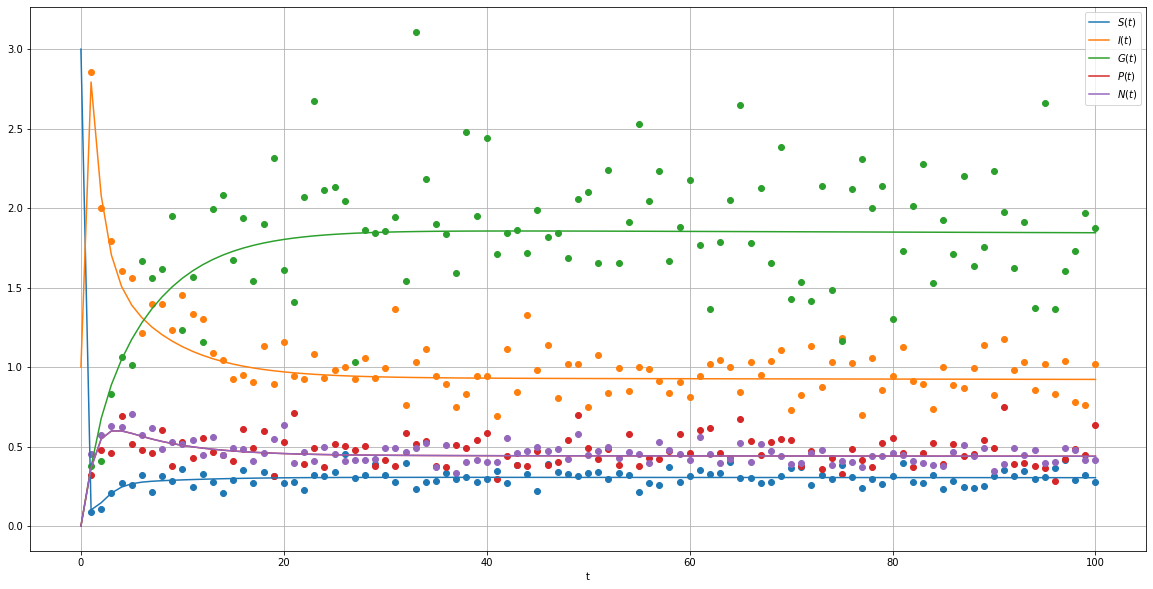

In [9]:
# Observational model
np.random.seed(123)

obs = np.random.lognormal(
    mean=np.log(sol[1::]), 
    sigma=np.random.uniform(0.1, 0.3, size=sol.shape[1])
)
    
model.plot(sol, "male", "high", "(25, 50)", obs=obs)

In [10]:
args = flatten_params(*(
    tfd.Dirichlet(np.ones((len(S_CATEGORIES),))).sample(),               # sip
    tfd.Beta(3, 2).sample(len(G_CATEGORIES)),                            # beta
    generate_social_interaction_matrix(),                                # c
    tfd.Exponential(1/2).sample(len(G_CATEGORIES)),                      # di
    tfd.Exponential(1/7).sample(len(G_CATEGORIES)),                      # wip
    tfd.Exponential(1/3).sample(len(G_CATEGORIES)),                      # dai
    tfd.Exponential(1/14).sample(len(G_CATEGORIES)),                     # dwt
    tfd.Dirichlet(np.ones((len(G_CATEGORIES),))).sample(),               # psc
    np.array([1825.]),                                                   # r
), framework=np).astype(np.float32)

def func(t, y):
    return tf.Variable(system(y, t, args, tf))

results = tfp.math.ode.BDF().solve(func, 0, state0, solution_times=t[:2])

Variational Inference (VI) methods are used to identify complex distributions as an alternative to the computationally costly (but very accurate) Markov chain Monte Carlo (MCMC) sampling. In general, MCMC provide guarantees of producing (asymptotically) exact samples from the target density [4, p.3]. In VI case, we use a less complex but still flexible **family** of distributions to approximate an intractable distribution. Some literature works on VI are

1. Information Theory, Inference and Learning Algorithms, David J. C. MacKay, David J. C. Mac Kay, Cambridge University Press, 2003
2. Bayesian Reasoning and Machine Learning, David Barber, Cambridge University Press, 2012
3. Pattern Recognition and Machine Learning, Christopher M. Bishop, Springer New York, 2016
4. Variational Inference: A Review for Statisticians, David M. Blei, Alp Kucukelbir, Jon D. McAuliffe, 2018
5. High-Level Explanation of Variational Inference, Jason Eisner, 2011

For business and academic projects, where Bayesian models are fitted on very large datasets (Big Data applications), approximate inference methods are a very efficient and optimised way of infering quite accurate results.


Assume that we want to use VI on a Bayesian regression, let $x$ be the independent variables with $X$ their matrix form and $y$ the continuous responce variable. The coefficients $\beta$ of the model follow a complex multimodal distribution. 

$$
y = \mathcal{N}(\beta^{T}X, \sigma^{2})
$$

in Bayesian form, we want to infer the posterior of the model, in other words the distribution of the coefficients

$$
p(\beta|y, X) = \frac{p(y|X, \beta)p(\beta|X)}{p(y)}
$$

The complexity of the posterior distribution means that we have two ways to compute the results

1. Use MCMC sampling methods (Gibb's, Hamiltonian)
2. Use approximate methods

To use approximate inference we follow the steps, that are similar to [1, 2, 4]

$$
\begin{aligned}
KL(q(\beta)||p(\beta|y, X)) &= \int q(\beta) \log\bigg(\frac{q(\beta)}{p(\beta|y, X)}\bigg) d\beta \\
&= \int q(\beta) \log(q(\beta)) d\beta - \int q(\beta) \log(p(\beta|y, X)) d\beta \\
&= \int q(\beta) \log(q(\beta)) d\beta - \int q(\beta) \log\bigg(\frac{p(y|\beta, X)p(\beta|X)}{p(y)}\bigg)d\beta \\
&= \int q(\beta) \log(q(\beta))d\beta - \int q(\beta) \log(p(y|\beta, X)p(\beta|X))d\beta + \log(p(y)) \\
&= \int q(\beta) \log(q(\beta))d\beta - \int q(\beta) \log(p(\beta|X))d\beta - \int q(\beta) \log(p(y|\beta, X))d\beta + \log(p(y)) \\
&= \int q(\beta) \log\bigg(\frac{q(\beta)}{p(\beta|X)}\bigg)d\beta - \int q(\beta) \log(p(y|\beta, X))d\beta + \log(p(y)) \\
&= KL(q(\beta)||p(\beta|X)) - \mathbb{E}_{q}(\log(p(y|\beta, X))) + \log(p(y))
\end{aligned}
$$

the RHS of the equation shows the entropy, the average energy and the evidence (marginal of $y$).
By setting the lower bound (and change the signs because we move the $\log(p(y))$ on the LHS) as

$$
ELBO(q) = \mathbb{E}_{q}(\log(p(y|\beta, X))) - KL(q(\beta)||p(\beta|X))
$$

and the previous formula becomes

$$
\log(p(y)) = ELBO(q) + KL(q(\beta)||p(\beta|y, X))
$$

which is similar to the formula that Bishop has in his book [3, p.463]

In [11]:
# sigma = tfd.HalfCauchy(
#     1, scale=1, name='HalfCauchy'
# )

In [12]:
# scale_HC = tf.dtypes.cast(sigma.sample(state0.shape[0]), tf.float32)
# score = tf.dtypes.cast(results[3][0][0], tf.float32)

In [13]:
# tfd.Dirichlet(np.ones((len(S_CATEGORIES),))).sample(),               # sip
#     tfd.Beta(3, 2).sample(len(G_CATEGORIES)),                            # beta
#     generate_social_interaction_matrix(),                                # c
#     tfd.Exponential(1/2).sample(len(G_CATEGORIES)),                      # di
#     tfd.Exponential(1/7).sample(len(G_CATEGORIES)),                      # wip
#     tfd.Exponential(1/3).sample(len(G_CATEGORIES)),                      # dai
#     tfd.Exponential(1/14).sample(len(G_CATEGORIES)),                     # dwt
#     tfd.Dirichlet(np.ones((len(G_CATEGORIES),))).sample(),               # psc
#     1825.,              

In [27]:
Root = tfd.JointDistributionCoroutine.Root
def model_fn():
    sip = yield Root(tfd.Dirichlet(np.ones((len(S_CATEGORIES),), dtype=np.float32), name="sip"))
    beta = yield Root(tfd.Sample(tfd.Beta(3, 2, name="beta"), sample_shape=(len(G_CATEGORIES),)))
    di = yield Root(tfd.Sample(tfd.Exponential(1/2, name="di"), sample_shape=(len(G_CATEGORIES),)))
    wip = yield Root(tfd.Sample(tfd.Exponential(1/7, name="wip"), sample_shape=(len(G_CATEGORIES),)))
    dai = yield Root(tfd.Sample(tfd.Exponential(1/3, name="dai"), sample_shape=(len(G_CATEGORIES),)))
    dwt = yield Root(tfd.Sample(tfd.Exponential(1/14, name="dwt"), sample_shape=(len(G_CATEGORIES),)))
    psc = yield Root(tfd.Dirichlet(np.ones((len(G_CATEGORIES),), dtype=np.float32), name="psc"))
    
    args_ = flatten_params(*(
        sip, 
        beta, 
        tf.constant(generate_social_interaction_matrix(), dtype=tf.float32),
        di, 
        wip, 
        dai, 
        dwt, 
        psc, 
        tf.constant(np.array([1825.]), dtype=tf.float32)
    ), framework=tf)
    
    def f(t, y):
        return tf.stack(system(y, t, args_, tf))
    bijector = tfb.FFJORD(
        f, 
        tfp.math.ode.BDF(use_pfor_to_compute_jacobian=False).solve, 
        trace_augmentation_fn=tfb.ffjord.trace_jacobian_exact, 
        dtype=tf.float32,
        initial_time=0.0,
        final_time=t[1],
    )
    y = bijector.forward(results.states[0])
    x = bijector.inverse(results.states[-1])
    base = tfd.Gamma(tf.ones_like(x) * 5., tf.ones_like(x))
    out = yield tfd.TransformedDistribution(base, bijector)
#     out = yield tfp.math.ode.BDF(use_pfor_to_compute_jacobian=False).solve(f, 0, results.states[0], solution_times=t[:2])
    
model = tfd.JointDistributionCoroutine(model_fn)

In [23]:
q_sip_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_sip_loc')
q_sip_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_sip_scale')
q_beta_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_beta_loc')
q_beta_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_beta_scale')
q_di_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_di_loc')
q_di_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_di_scale')
q_wip_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_wip_loc')
q_wip_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_wip_scale')
q_dai_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_dai_loc')
q_dai_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_dai_scale')
q_dwt_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_dwt_loc')
q_dwt_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_dwt_scale')
q_psc_loc = tf.Variable(tf.zeros((len(S_CATEGORIES),)), name='q_psc_loc')
q_psc_scale = tf.Variable(tf.ones((len(S_CATEGORIES),)), name='q_psc_scale')

def variational_model_fn():
    sip = yield Root(tfd.Normal(loc=q_sip_loc, scale=tf.nn.softplus(q_sip_scale)))
    beta = yield Root(tfd.Normal(loc=q_beta_loc, scale=tf.nn.softplus(q_beta_scale)))
    di = yield Root(tfd.Normal(loc=q_di_loc, scale=tf.nn.softplus(q_di_scale)))
    wip = yield Root(tfd.Normal(loc=q_wip_loc, scale=tf.nn.softplus(q_wip_scale)))
    dai = yield Root(tfd.Normal(loc=q_dai_loc, scale=tf.nn.softplus(q_dai_scale)))
    dwt = yield Root(tfd.Normal(loc=q_dwt_loc, scale=tf.nn.softplus(q_dwt_scale)))
    psc = yield Root(tfd.Normal(loc=q_psc_loc, scale=tf.nn.softplus(q_psc_scale)))
    
    args_ = flatten_params(*(
        sip, 
        beta, 
        tf.constant(generate_social_interaction_matrix(), dtype=tf.float32),
        di, 
        wip, 
        dai, 
        dwt, 
        psc, 
        tf.constant(np.array([1825.]), dtype=tf.float32)
    ), framework=tf)
    
    y = yield tfd.VectorDeterministic(args_)
q = tfd.JointDistributionCoroutine(variational_model_fn)

### !!! TODO: FIXME !!!!

In [ ]:
def f(t, y):
    return tf.stack(system(y, t, args, tf))
bijector = tfb.FFJORD(
    f, 
    tfp.math.ode.BDF(use_pfor_to_compute_jacobian=False).solve, 
    trace_augmentation_fn=tfb.ffjord.trace_jacobian_exact, 
    dtype=tf.float32,
    initial_time=0.0,
    final_time=t[1],
)
y = bijector.forward(results.states[0])
x = bijector.inverse(results.states[-1])
base = tfd.Gamma(tf.ones_like(x) * 5., tf.ones_like(x))
out = tfd.TransformedDistribution(base, bijector)

Instructions for updating:
Use tf.identity instead.


In [20]:
# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Utility function to construct the diagonal of a Jacobian matrix."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow.compat.v2 as tf

from tensorflow_probability.python.math.gradient import value_and_gradient


def diag_jacobian2(xs,
                  ys=None,
                  sample_shape=None,
                  fn=None,
                  parallel_iterations=10,
                  name=None):

    with tf.name_scope(name or 'jacobians_diag'):
        if sample_shape is None:
            sample_shape = [1]
        # Output Jacobian diagonal
        jacobians_diag_res = []
        # Convert input `xs` to a list
        xs = list(xs) if _is_list_like(xs) else [xs]
        xs = [tf.convert_to_tensor(x) for x in xs]
        if not tf.executing_eagerly():
            if ys is None:
                if fn is None:
                    raise ValueError('Both `ys` and `fn` can not be `None`')
                else:
                    ys = fn(*xs)
            # Convert ys to a list
#             raise ValueError(ys)
            ys = list(ys) if _is_list_like(ys) else [ys]
            if len(xs) != len(ys):
                raise ValueError('`xs` and `ys` should have the same length')
            for y, x in zip(ys, xs):
                # Broadcast `y` to the shape of `x`.
                y_ = y + tf.zeros_like(x)
                # Change `event_shape` to one-dimension
                y_ = tf.reshape(y, tf.concat([sample_shape, [-1]], -1))

                # Declare an iterator and tensor array loop variables for the gradients.
                n = tf.size(x) / tf.cast(tf.reduce_prod(sample_shape), dtype=tf.int32)
                n = tf.cast(n, dtype=tf.int32)
                loop_vars = [
                    0,
                    tf.TensorArray(x.dtype, n)
                ]

                def loop_body(j):
                    """Loop function to compute gradients of the each direction."""
                    # Gradient along direction `j`.
                    res = tf.gradients(ys=y_[..., j], xs=x)[0]  # pylint: disable=cell-var-from-loop
                    if res is None:
                    # Return zero, if the gradient is `None`.
                        res = tf.zeros(tf.concat([sample_shape, [1]], -1),
                           dtype=x.dtype)  # pylint: disable=cell-var-from-loop
                    else:
                        # Reshape `event_shape` to 1D
                        res = tf.reshape(res, tf.concat([sample_shape, [-1]], -1))
                        # Add artificial dimension for the case of zero shape input tensor
                        res = res[tf.newaxis, ..., j]
                    return res  # pylint: disable=cell-var-from-loop

            # Iterate over all elements of the gradient and compute second order
            # derivatives.
            _, jacobian_diag_res = tf.while_loop(
                cond=lambda j, _: j < n,  # pylint: disable=cell-var-from-loop
                body=lambda j, result: (j + 1, result.write(j, loop_body(j))),
                loop_vars=loop_vars,
                parallel_iterations=parallel_iterations)

            shape_x = tf.shape(x)
            # Stack gradients together and move flattened `event_shape` to the
            # zero position
            reshaped_jacobian_diag = tf.transpose(a=jacobian_diag_res.stack())
            # Reshape to the original tensor
            reshaped_jacobian_diag = tf.reshape(reshaped_jacobian_diag, shape_x)
            jacobians_diag_res.append(reshaped_jacobian_diag)

        else:
            if fn is None:
                raise ValueError('`fn` can not be `None` when eager execution is '
                         'enabled')
            if ys is None:
                ys = fn(*xs)

            def fn_slice(i, j):
                """Broadcast y[i], flatten event shape of y[i], return y[i][..., j]."""
                def fn_broadcast(*state):
                    res = fn(*state)
                    res = list(res) if _is_list_like(res) else [res]
                    if len(res) != len(state):
                        res *= len(state)
                        res = [tf.reshape(r + tf.zeros_like(s),
                            tf.concat([sample_shape, [-1]], -1))
                        for r, s in zip(res, state)]
                    return res
                # Expand dimensions before returning in order to support 0D input `xs`
                return lambda *state: tf.expand_dims(fn_broadcast(*state)[i], 0)[..., j]

            def make_loop_body(i, x):
                """Loop function to compute gradients of the each direction."""
                def _fn(j, result):
                    res = value_and_gradient(fn_slice(i, j), xs)[1][i]
                    if res is None:
                        res = tf.zeros(sample_shape, dtype=x.dtype)
                    else:
                        res = tf.reshape(res, tf.concat([sample_shape, [-1]], -1))
                        res = res[..., j]
                    return j + 1, result.write(j, res)
                return _fn

            for i, x in enumerate(xs):
                # Declare an iterator and tensor array loop variables for the gradients.
                n = tf.size(x) / tf.cast(tf.reduce_prod(sample_shape), dtype=tf.int32)
                n = tf.cast(n, dtype=tf.int32)
                loop_vars = (0, tf.TensorArray(x.dtype, n, element_shape=sample_shape))

                # Iterate over all elements of the gradient and compute second order
                # derivatives.
                _, jacobian_diag_res = tf.while_loop(
                    cond=lambda j, _: j < n,
                    body=make_loop_body(i, x),
                    loop_vars=loop_vars,
                    parallel_iterations=parallel_iterations)

                shape_x = tf.shape(x)
                # Stack gradients together and move flattened `event_shape` to the
                # zero position
                reshaped_jacobian_diag = tf.transpose(a=jacobian_diag_res.stack())
                # Reshape to the original tensor
                reshaped_jacobian_diag = tf.reshape(reshaped_jacobian_diag, shape_x)
                jacobians_diag_res.append(reshaped_jacobian_diag)

    return ys, jacobians_diag_res


def _is_list_like(x):
    """Helper which returns `True` if input is `list`-like."""
    return isinstance(x, (tuple, list))

tfb.ffjord.tfp_math.diag_jacobian = diag_jacobian2

In [28]:
losses = tfp.vi.fit_surrogate_posterior(
  target_log_prob_fn=lambda *args: model.log_prob(args),
  surrogate_posterior=q,
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  sample_size=1,
  num_steps=500
)

ValueError: Input tensor 'Const_1:0' enters the loop with shape (), but has shape <unknown> after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.

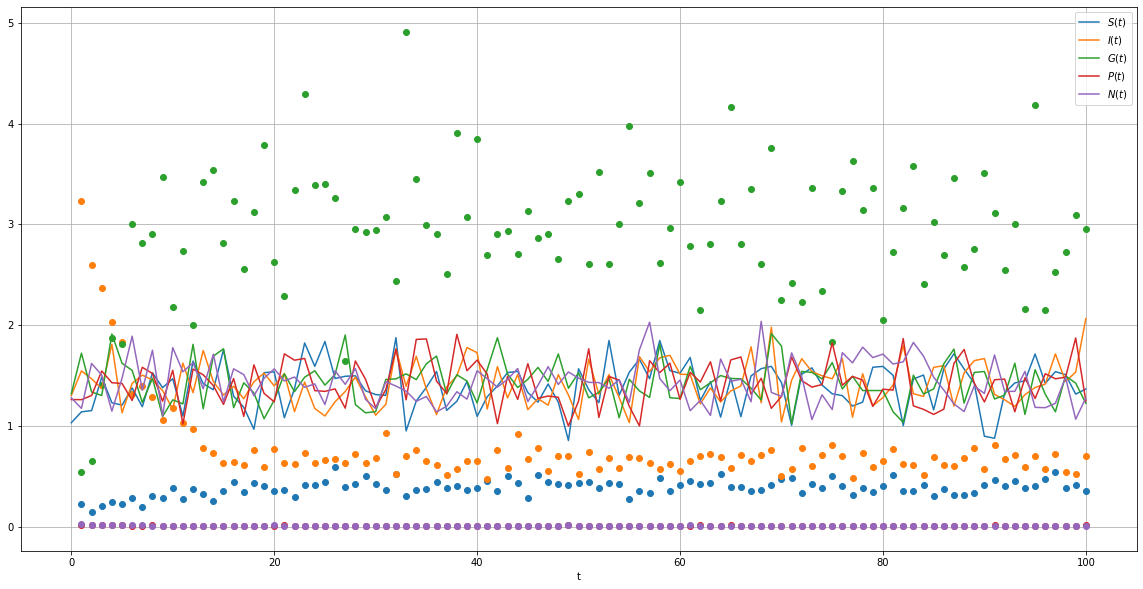

In [36]:
model.plot(
    q.sample(101), 
    "male", 
    "high", 
    "(25, 50)", 
    obs=obs
)

## Example

In [38]:
# Toy 1D data.
index_points = np.array([-10., -7.2, -4., -0.1, 0.1, 4., 6.2, 9.]).reshape(
    [-1, 1]).astype(np.float32)
observed_counts = np.array(
    [100, 90, 60, 13, 18, 37, 55, 42]).astype(np.float32)

# Trainable GP hyperparameters.
kernel_log_amplitude = tf.Variable(0., name='kernel_log_amplitude')
kernel_log_lengthscale = tf.Variable(0., name='kernel_log_lengthscale')
observation_noise_log_scale = tf.Variable(
  0., name='observation_noise_log_scale')

# Generative model.
Root = tfd.JointDistributionCoroutine.Root
def model_fn():
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.exp(kernel_log_amplitude),
      length_scale=tf.exp(kernel_log_lengthscale))
    latent_log_rates = yield Root(tfd.GaussianProcess(
      kernel,
      index_points=index_points,
      observation_noise_variance=tf.exp(observation_noise_log_scale),
      name='latent_log_rates'))
    y = yield tfd.Independent(tfd.Poisson(log_rate=latent_log_rates, name='y'),
                            reinterpreted_batch_ndims=1)
model = tfd.JointDistributionCoroutine(model_fn)

In [39]:
logit_locs = tf.Variable(tf.zeros(observed_counts.shape), name='logit_locs')
logit_softplus_scales = tf.Variable(tf.ones(observed_counts.shape) * -4,
                                    name='logit_softplus_scales')
def variational_model_fn():
    latent_rates = yield Root(tfd.Independent(
    tfd.Normal(loc=logit_locs, scale=tf.nn.softplus(logit_softplus_scales)),
    reinterpreted_batch_ndims=1))
    y = yield tfd.VectorDeterministic(latent_rates)
q = tfd.JointDistributionCoroutine(variational_model_fn)

In [40]:
losses, log_amplitude_path, sample_path = tfp.vi.fit_surrogate_posterior(
  target_log_prob_fn=lambda *args: model.log_prob(args),
  surrogate_posterior=q,
  optimizer=tf.optimizers.Adam(learning_rate=0.1),
  sample_size=1,
  num_steps=500,
  trace_fn=lambda loss, grads, vars: (loss, kernel_log_amplitude,
                                      q.sample(5, seed=42)[0]))

In [41]:
model.sample(), q.sample()

((<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-2.3941154 , -0.09614992,  0.771525  , -1.4176776 ,  0.32875705,
          0.893997  , -1.5008167 , -0.5344367 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 4., 0., 0., 3., 0., 0.], dtype=float32)>),
 (<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-6.0753107 , -6.1401367 , -0.53637695, -1.7946572 , -2.9305344 ,
         -3.530294  , -3.1744535 , -2.0744176 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-6.0753107 , -6.1401367 , -0.53637695, -1.7946572 , -2.9305344 ,
         -3.530294  , -3.1744535 , -2.0744176 ], dtype=float32)>))